## More Feature Exploration

Sunya Abbasi 
10/16

In this notebook, I will be adding onto my work from last week. In the first section, I revisit the relationship between numerical values in quotes and source type. I am now additionally looking at number words such as: hundred, thousand, million, billion. I also explore just the existence of numerical values in the quotes as a feature and look at the frequency of quotes in each source type that contain numerical values (numbers or number words).

In [151]:
#importing in libraries
import pandas as pd
import numpy as np
import regex as re
import string
import matplotlib.pyplot as plt

In [152]:
#loading in sample dataframe
df = pd.read_csv("Data/cleaned_data/GNI88_cleaned_sample.csv")

### Exploring the Relationship between Numerical Values in Quotes and Source Type

In [153]:
def number_count(text):
    """ Input: text string
        Output: number of numerical values in the text
        The function accounts for the fact that there is 
        sometimes commas and decimals in numbers """
    text_wo_punct = text.replace(",", "").replace(".", "")
    return len(re.findall("[0-9]+", text_wo_punct))

#### Example to Demonstrate how number_count Function Works

In [154]:
df["QText"][28]

"The president’s $15.5 billion request for weapons program at the Energy Department's National Nuclear Security Administration, or NNSA, “meets requirements” and is a “minimally sufficient” amount of funding"

In [155]:
number_count(df["QText"][28])

1

In [72]:
number_count("9.1 is bigger than 6 but smaller than 1,000")

3

In [73]:
# number_counts array stores the count of numbers for the "QText" feature in every row of the df
number_counts = []
for i in df['QText']:
    if type(i) == float:
        number_counts.append(0)
    else:
        number_counts.append(number_count(i))

In [74]:
# sourcetype_numbercounts DataFrame holds the Average Count of numbers in the "QText"s of each Source Type
data = {'Source Type' : df["Source Type"], "Count of numbers": number_counts}
sourcetype_numbercounts = pd.DataFrame(data)
sourcetype_numbercounts = sourcetype_numbercounts.groupby(["Source Type"]).mean().rename(columns = {"Count of numbers": "Mean Number Count"})
sourcetype_numbercounts = sourcetype_numbercounts.sort_values(by = "Mean Number Count")

In [145]:
# all_counts DataFrame is same as sourcetype_numbercounts with additional column 
# holding a list of the data used to calculate the averages
all_counts = pd.DataFrame(data)
all_counts = all_counts.groupby(["Source Type"]).agg(list)
all_counts = all_counts.rename(columns = {"Count of numbers": "Number Counts"})
sourcetype_numbercounts["Number Counts"] = all_counts["Number Counts"]
sourcetype_numbercounts.head()

,Mean Number Count,Number Counts
Source Type,,
Nuclear Scientist,0.000000,[0]
Terrorist/Extremist,0.000000,"[0, 0]"
Religious/Clerical,0.000000,"[0, 0]"
Citizen,0.038462,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
Corporate Official,0.090909,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


The next 4 cells are code from Models/speaker_classification/speaker_classifiers_v1.ipynb. They are being used to further classify the speaker types into 8 distinct categories.

In [76]:
# dictionary containing the classification groups for all speaker types
source_groups = {"Foreign Government": ['Foreign Gov/Mil Official'],
                "Experts": ['Nuke Organization','Non-Profit/NGO','Think Tanks',
                            'Nuke Organization - Other', 'Nuke Organization - Academic',
                            'International Orgs','Academic','Nuclear Scientist',"Analyst/Commentator",
                            'Attorney','Regulator'],
                "US Congress": ['US Rep. & Staff','US Senate & Staff', 'Partisans/Fmr. Politicians'],
                "US Federal Officials": ['Federal Official','State/Local Official',
                                        'Former Admin. Officials','Judicial Official'],
                "US Defense": ['US Military','Defense Forces','Defense', 'Military'],
                "Media": ["Media/Journalist","Blogger"],
                "Corporate Official": ['Corporate Official'],
                "Other": ['Other','Chairman','Terrorist/Extremist','Information minister',
                          'Religious/Clerical', 'Ambassador', 'Nuclear Official',
                          'Citizen','Public Polling','US Police','Deputy']}

In [77]:
# Helper function that inverts a dictionary. This will be useful for using speaker groups
# later on in model evaluation
def invert_dict(dictionary):
  """Inputs:
     - dictionary: dict, dictionary we wish to invert
     Outputs:
     - dict, where keys are the initial dictionary's values and values are the initial dictionary's keys"""
  # get a list of all items in all dictionary values
  speaker_types = list(np.concatenate(list(dictionary.values())).flat)
  # each speaker type will become its own key now, and the value will be the speaker group it's a part of
  inverted_dict = {}
  for speaker_type in speaker_types:
    # find the group the speaker_type belongs in
    speaker_group = [key for key, value in dictionary.items() if speaker_type in value][0]
    # update the inverted dictionary such that the key is the speaker type and the value is the speaker group
    inverted_dict[speaker_type] = speaker_group
  return inverted_dict

In [78]:
# lookup dictionary which can convert a speaker type to its classification group in constant time
source_to_group = invert_dict(source_groups)

In [79]:
def assign_source_to_group(source_type):
  """Inputs:
     - source_type: str, source type from quote datafame
     Outputs:
     - str of the bigger speaker category to which source_type belongs"""
  if type(source_type) != str:
    return "Other"
  else:
    return source_to_group[source_type]

In [80]:
# groupedtype DataFrame holds the average amount of numbers in the QText of each 
# "Source Group"
groupedtype = pd.DataFrame(data)
groupedtype["Source Group"] = df["Source Type"].apply(assign_source_to_group)
groupedtype = groupedtype.drop(columns = ["Source Type"])
groupedtype = groupedtype.groupby("Source Group").agg(list)
averages = []
for i in groupedtype["Count of numbers"]:
    averages.append(sum(i)/ len(i))
groupedtype["Average Number Count"] = averages
groupedtype = groupedtype.sort_values("Average Number Count")
groupedtype

,Count of numbers,Average Number Count
Source Group,,
Corporate Official,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.090909
US Congress,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.108491
US Federal Officials,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.127049
Foreign Government,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, ...",0.158436
Media,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.201835
US Defense,"[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.232558
Other,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.297619
Experts,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.337808


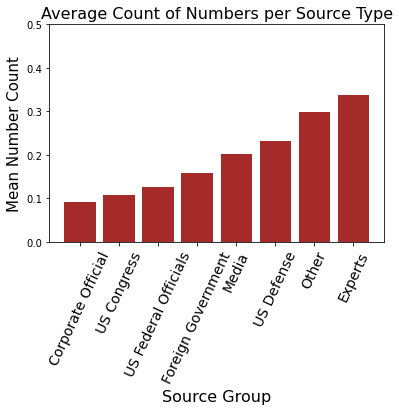

In [81]:
# making bar chart to visualize
plt.bar(x = groupedtype.index.to_series(), height = groupedtype["Average Number Count"], color = "brown")
plt.title("Average Count of Numbers per Source Type", fontdict = {'fontsize' : 16})
plt.ylim(0, 0.5)
plt.xlabel("Source Group", fontdict = {'fontsize' : 16})
plt.ylabel("Mean Number Count", fontdict = {'fontsize' : 15})
plt.xticks(np.arange(8), groupedtype.index.to_series(), fontdict = {'fontsize' : 14}, rotation= 65);

## Looking at Numbers and Number Words
Number words are numbers that are written out. For example, "one hundred."

In [92]:
# This function returns the count of numerical values, and appearance of the words: "hundred(s)", 
# "thousand(s)", "million(s)", and "billion(s)"
def number_and_numwords_count(text):
    """ Input: text string
        Output: number of numerical values and number words in the text
        The function accounts for the fact that there is 
        sometimes commas and decimals in numbers """
    text_clean = text.replace(",", "").replace(".", "").lower()
    hundreds = len(re.findall(r"\bhundred[s]{0,1}\b", text_clean))
    thousands = len(re.findall(r"\bthousand[s]{0,1}\b", text_clean))
    millions = len(re.findall(r"\bmillion[s]{0,1}\b", text_clean))
    billions = len(re.findall(r"\bbillion[s]{0,1}\b", text_clean))
    total = len(re.findall("[0-9]+", text_clean)) + hundreds + thousands + millions + billions
    return total

### Example for number_and_numwords_count function


In [146]:
df["QText"][28]

"The president’s $15.5 billion request for weapons program at the Energy Department's National Nuclear Security Administration, or NNSA, “meets requirements” and is a “minimally sufficient” amount of funding"

In [147]:
number_and_numwords_count(df["QText"][28])

2

In [93]:
#example to show how the number_and_numwords_count function works but also how it may be inaccurate

number_and_numwords_count("I have 5 million and 30 thousand sheep. She has hundreds of billions of dollars")

6

In [95]:
# number_word_counts array stores the count of numbers for the "QText" feature in every row of the df
number_word_counts = []
for i in df['QText']:
    if type(i) == float:
        number_word_counts.append(0)
    else:
        number_word_counts.append(number_and_numwords_count(i))

In [96]:
# sourcetype_numberword_counts DataFrame holds the Average Count of numbers and number words 
# in the "QText"s of each Source Type
dataX = {'Source Type' : df["Source Type"], "Count of numbers and number words": number_word_counts}
sourcetype_numberword_counts = pd.DataFrame(dataX)
sourcetype_numberword_counts = sourcetype_numberword_counts.groupby(["Source Type"]).mean().rename(columns = {"Count of numbers and number words": "Mean Number Count"})
sourcetype_numberword_counts = sourcetype_numberword_counts.sort_values(by = "Mean Number Count")


In [129]:
# all_number_words DataFrame is same as sourcetype_numberword_counts with additional column 
# holding a list of the data used to calculate the averages
all_number_words = pd.DataFrame(dataX)
all_number_words = all_number_words.groupby(["Source Type"]).agg(list)
all_number_words = all_number_words.rename(columns = {"Count of numbers and number words": "Number Counts"})
sourcetype_numberword_counts["Number Counts"] = all_counts["Number Counts"]
sourcetype_numberword_counts.head()

,Mean Number Count,Number Counts
Source Type,,
Nuclear Scientist,0.000000,[0]
Terrorist/Extremist,0.000000,"[0, 0]"
Religious/Clerical,0.000000,"[0, 0]"
Citizen,0.038462,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
Blogger,0.100000,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"


In [99]:
# groupedtype1 DataFrame holds the average amount of numbers and number words in the QText of each 
# "Source Group"
groupedtype1 = pd.DataFrame(dataX)
groupedtype1["Source Group"] = df["Source Type"].apply(assign_source_to_group)
groupedtype1 = groupedtype1.drop(columns = ["Source Type"])
groupedtype1 = groupedtype1.groupby("Source Group").agg(list)
averagesX = []
for i in groupedtype1["Count of numbers and number words"]:
    averagesX.append(sum(i)/ len(i))
groupedtype1["Average Number Count"] = averagesX
groupedtype1 = groupedtype1.sort_values("Average Number Count")
groupedtype1

,Count of numbers and number words,Average Number Count
Source Group,,
US Congress,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.122642
Corporate Official,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.136364
US Federal Officials,"[0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.153689
Foreign Government,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, ...",0.172840
Media,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.238532
US Defense,"[0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.279070
Other,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.321429
Experts,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.371365


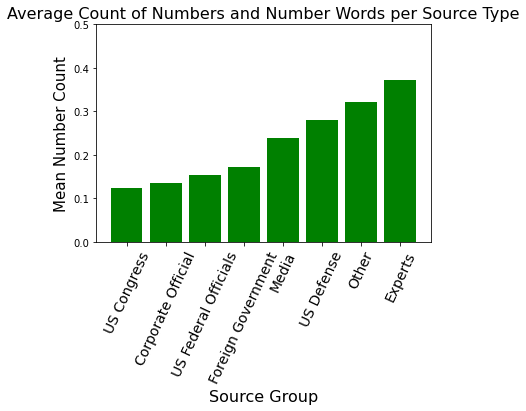

In [107]:
# making bar chart to visualize
plt.bar(x = groupedtype1.index.to_series(), height = groupedtype1["Average Number Count"], color = "green")
plt.title("Average Count of Numbers and Number Words per Source Type", fontdict = {'fontsize' : 16})
plt.ylim(0, 0.5)
plt.xlabel("Source Group", fontdict = {'fontsize' : 16})
plt.ylabel("Mean Number Count", fontdict = {'fontsize' : 15})
plt.xticks(np.arange(8), groupedtype1.index.to_series(), fontdict = {'fontsize' : 14}, rotation= 65);

## Looking at the Frequency of Quotes in each Source Category that use Numerical Values

In [133]:
#has_num_array contains 1 for "QText"s that have a numerical value or number word and 0 for "QText"s that do not
has_num_array = []
for i in number_word_counts:
    if i > 0:
        has_num_array.append(1)
    else:
        has_num_array.append(0)


In [137]:
#has_numerical_value dataframe contains the frequency of Quotes with a numerical value for each source type
dataC = {'Source Type' : df["Source Type"], "Has Numerical Value": has_num_array}
has_numerical_value = pd.DataFrame(dataC)
has_numerical_value = has_numerical_value.groupby("Source Type").agg(list)
averages1C = []
for i in has_numerical_value["Has Numerical Value"]:
    averages1C.append(sum(i)/ len(i))
has_numerical_value["Frequency of Quotes with Numerical Value"] = averages1C
has_numerical_value = has_numerical_value.sort_values("Frequency of Quotes with Numerical Value")
has_numerical_value.head()

,Has Numerical Value,Frequency of Quotes with Numerical Value
Source Type,,
Nuclear Scientist,[0],0.000000
Terrorist/Extremist,"[0, 0]",0.000000
Religious/Clerical,"[0, 0]",0.000000
Citizen,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0.038462
Regulator,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",0.062500


In [139]:
# grouped_has_num dataframe contains the frequency of Quotes with a numerical value for each Source Group
grouped_has_num = pd.DataFrame(dataC)
grouped_has_num["Source Group"] = df["Source Type"].apply(assign_source_to_group)
grouped_has_num = grouped_has_num.drop(columns = ["Source Type"])
grouped_has_num = grouped_has_num.groupby("Source Group").agg(list)
averages2C = []
for i in grouped_has_num["Has Numerical Value"]:
    averages2C.append(sum(i)/ len(i))
grouped_has_num["Frequency of Quotes with Numerical Value"] = averages2C
grouped_has_num = grouped_has_num.sort_values("Frequency of Quotes with Numerical Value")
grouped_has_num

,Has Numerical Value,Frequency of Quotes with Numerical Value
Source Group,,
Corporate Official,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.090909
US Congress,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.094340
US Federal Officials,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.106557
Foreign Government,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",0.113169
US Defense,"[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.162791
Media,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.169725
Experts,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.176734
Other,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.190476


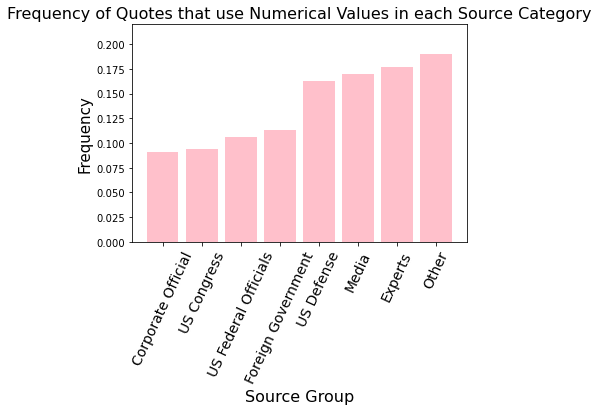

In [143]:
# making bar chart to visualize
plt.bar(x = grouped_has_num.index.to_series(), height = grouped_has_num["Frequency of Quotes with Numerical Value"], color = "pink")
plt.title("Frequency of Quotes that use Numerical Values in each Source Category", fontdict = {'fontsize' : 16})
plt.ylim(0, 0.22)
plt.xlabel("Source Group", fontdict = {'fontsize' : 16})
plt.ylabel("Frequency", fontdict = {'fontsize' : 15})
plt.xticks(np.arange(8), grouped_has_num.index.to_series(), fontdict = {'fontsize' : 14}, rotation= 65);

## Visualizations for the Possible Numerical Values Features
Remaking all of the visualizations for this section so that it is easier to compare bar charts.

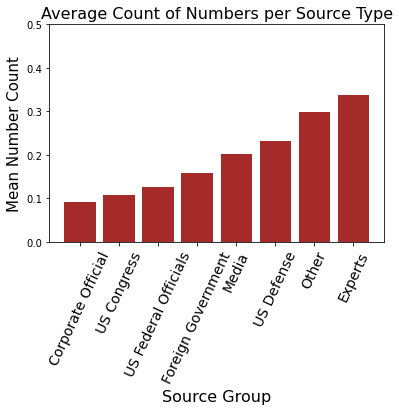

In [148]:
plt.bar(x = groupedtype.index.to_series(), height = groupedtype["Average Number Count"], color = "brown")
plt.title("Average Count of Numbers per Source Type", fontdict = {'fontsize' : 16})
plt.ylim(0, 0.5)
plt.xlabel("Source Group", fontdict = {'fontsize' : 16})
plt.ylabel("Mean Number Count", fontdict = {'fontsize' : 15})
plt.xticks(np.arange(8), groupedtype.index.to_series(), fontdict = {'fontsize' : 14}, rotation= 65);

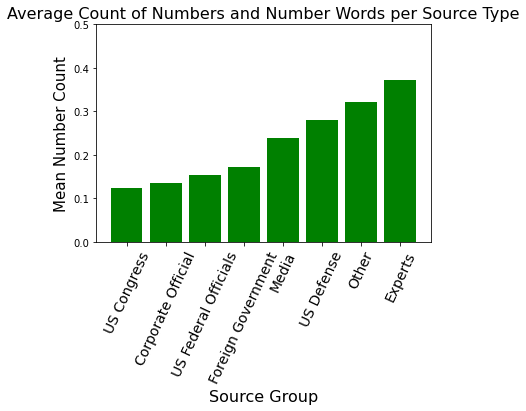

In [149]:
plt.bar(x = groupedtype1.index.to_series(), height = groupedtype1["Average Number Count"], color = "green")
plt.title("Average Count of Numbers and Number Words per Source Type", fontdict = {'fontsize' : 16})
plt.ylim(0, 0.5)
plt.xlabel("Source Group", fontdict = {'fontsize' : 16})
plt.ylabel("Mean Number Count", fontdict = {'fontsize' : 15})
plt.xticks(np.arange(8), groupedtype1.index.to_series(), fontdict = {'fontsize' : 14}, rotation= 65);

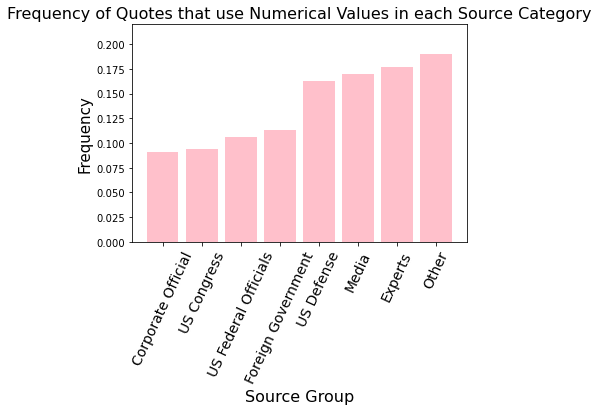

In [150]:
plt.bar(x = grouped_has_num.index.to_series(), height = grouped_has_num["Frequency of Quotes with Numerical Value"], color = "pink")
plt.title("Frequency of Quotes that use Numerical Values in each Source Category", fontdict = {'fontsize' : 16})
plt.ylim(0, 0.22)
plt.xlabel("Source Group", fontdict = {'fontsize' : 16})
plt.ylabel("Frequency", fontdict = {'fontsize' : 15})
plt.xticks(np.arange(8), grouped_has_num.index.to_series(), fontdict = {'fontsize' : 14}, rotation= 65);

## Looking at Words that Represent a Group

In [49]:
words = ["we", "our", "us", "ours"]

In [60]:
#takes in a string and returns the amount of "we", "our", "ours", and "us" that appear in it
def word_count(text):
    text_lowercase = text.lower()
    text_clean = text_lowercase.translate(str.maketrans('','', string.punctuation))
    sum_words = len(re.findall(r"\bus\b", text_clean)) 
    + len(re.findall(r"\bour\b", text_clean)) 
    + len(re.findall(r"\bwe\b", text_clean)) + len(re.findall(r"\bours\b", text_clean))
    return sum_words

In [55]:
# word_counts array holds the amount of "we", "our", "ours", and "us" in each "QText" in the df
word_counts = []
for i in df['QText']:
    if type(i) == float:
        word_counts.append(0)
    else:
        word_counts.append(word_count(i))

In [130]:
# source_and_word_count DataFrame holds average counts of the words "we", "our", and "us" 
# for all "Source Type"s
data1 = {"Source Type": df["Source Type"], "Word Count": word_counts}
source_and_word_count = pd.DataFrame(data1)
source_and_word_count = source_and_word_count.groupby("Source Type").agg(list)
averages1 = []
for i in source_and_word_count["Word Count"]:
    averages1.append(sum(i)/ len(i))
source_and_word_count["Average Word Count"] = averages1
source_and_word_count = source_and_word_count.sort_values("Average Word Count")
source_and_word_count.head()

,Word Count,Average Word Count
Source Type,,
Nuclear Scientist,[0],0.0
Terrorist/Extremist,"[0, 0]",0.0
Attorney,"[0, 0, 0, 0]",0.0
Religious/Clerical,"[0, 0]",0.0
Regulator,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0


In [110]:
# grouped_word DataFrame holds average counts of the words "we", "our","ours", and "us" 
# for all "Source Group"s
grouped_word = pd.DataFrame(data1)
grouped_word["Source Group"] = df["Source Type"].apply(assign_source_to_group)
grouped_word = grouped_word.drop(columns = ["Source Type"])
grouped_word = grouped_word.groupby("Source Group").agg(list)
averages2 = []
for i in grouped_word["Word Count"]:
    averages2.append(sum(i)/ len(i))
grouped_word["Average Word Count"] = averages2
grouped_word = grouped_word.sort_values("Average Word Count")
grouped_word

,Word Count,Average Word Count
Source Group,,
Other,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.083333
Corporate Official,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0.090909
US Congress,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0.108491
Foreign Government,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.113169
US Federal Officials,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0.184426
Experts,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.201342
Media,"[0, 0, 1, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, ...",0.275229
US Defense,"[2, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 2, 1, ...",0.302326


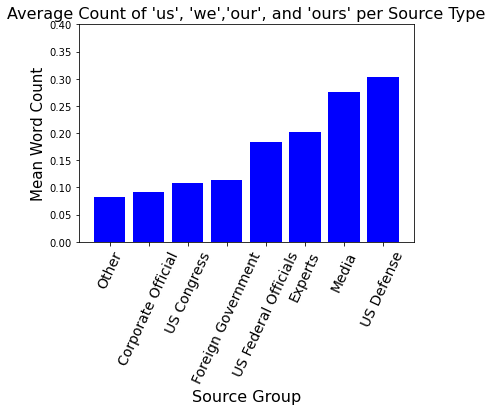

In [111]:
# making bar chart to visualize
plt.bar(x = grouped_word.index.to_series(), height = grouped_word["Average Word Count"], color = "blue")
plt.title("Average Count of 'us', 'we','our', and 'ours' per Source Type", fontdict = {'fontsize' : 16})
plt.ylim(0, 0.4)
plt.xlabel("Source Group", fontdict = {'fontsize' : 16})
plt.ylabel("Mean Word Count", fontdict = {'fontsize' : 15})
plt.xticks(np.arange(8), grouped_word.index.to_series(), fontdict = {'fontsize' : 14}, rotation= 65);

### Using frequency of words rather than count

In [125]:
#length_array holds the number of words in each String in df["QText"]
length_array = []
for i in df['QText']:
    if type(i) == float:
        length_array.append(0)
    else:
        length_array.append(len(i.split()))
        

In [144]:
# source_and_word_freq dataframe contains the Average frequency of "group words" for each source type 
frequencies = np.array(word_counts) / np.array(length_array)
dataA = {"Source Type": df["Source Type"], "Word Frequency": frequencies}
source_and_word_freq = pd.DataFrame(dataA)
source_and_word_freq = source_and_word_freq.groupby("Source Type").agg(list)
averagesA = []
for i in source_and_word_freq["Word Frequency"]:
    averagesA.append(sum(i)/ len(i))
source_and_word_freq["Average Word Frequency"] = averagesA
source_and_word_freq = source_and_word_freq.sort_values("Average Word Frequency")
source_and_word_freq.head()

,Word Frequency,Average Word Frequency
Source Type,,
Nuclear Scientist,[0.0],0.0
Terrorist/Extremist,"[0.0, 0.0]",0.0
Attorney,"[0.0, 0.0, 0.0, 0.0]",0.0
Religious/Clerical,"[0.0, 0.0]",0.0
Regulator,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0


In [159]:
# grouped_word_freq dataframe contains the Average frequency of "group words" for each source group 
grouped_word_freq = pd.DataFrame(dataA)
grouped_word_freq["Source Group"] = df["Source Type"].apply(assign_source_to_group)
grouped_word_freq = grouped_word_freq.drop(columns = ["Source Type"])
grouped_word_freq = grouped_word_freq.groupby("Source Group").agg(list)
averagesB = []
for i in grouped_word_freq["Word Frequency"]:
    averagesB.append(sum(i)/ len(i))
grouped_word_freq["Average Word Frequency"] = averagesB
grouped_word_freq = grouped_word_freq.sort_values("Average Word Frequency")
grouped_word_freq

,Word Frequency,Average Word Frequency
Source Group,,
Other,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.002686
US Congress,"[0.0, 0.0, 0.0, 0.0, 0.047619047619047616, 0.0...",0.003817
Foreign Government,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0,...",0.004704
Corporate Official,"[0.0, 0.0, 0.07692307692307693, 0.0, 0.0, 0.0,...",0.005012
Experts,"[0.0, 0.011904761904761904, 0.0, 0.0, 0.018867...",0.005190
US Federal Officials,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.007130
Media,"[0.0, 0.0, 0.03333333333333333, 0.034883720930...",0.007246
US Defense,"[0.06666666666666667, 0.0, 0.0, 0.0, 0.0476190...",0.009194


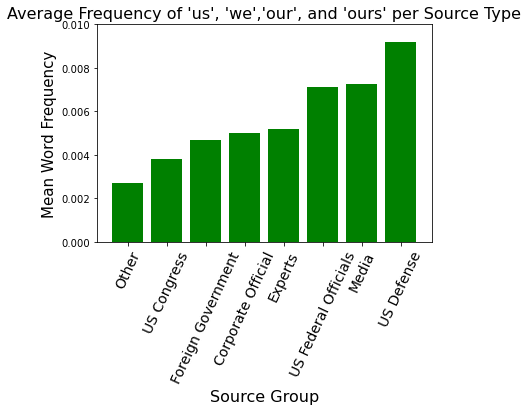

In [158]:
# making bar chart to visualize
plt.bar(x = grouped_word_freq.index.to_series(), height = grouped_word_freq["Average Word Frequency"], color = "green")
plt.title("Average Frequency of 'us', 'we','our', and 'ours' per Source Type", fontdict = {'fontsize' : 16})
plt.ylim(0, 0.01)
plt.xlabel("Source Group", fontdict = {'fontsize' : 16})
plt.ylabel("Mean Word Frequency", fontdict = {'fontsize' : 15})
plt.xticks(np.arange(8), grouped_word_freq.index.to_series(), fontdict = {'fontsize' : 14}, rotation= 65);

## Visualizations for "Group Words" Count and Frequency
The next two cells are the Average "Group Words" Counts bar chart and the Average "Group Words" Frequency bar chart. I put them here so we can more easily compare the change in order of source categories.

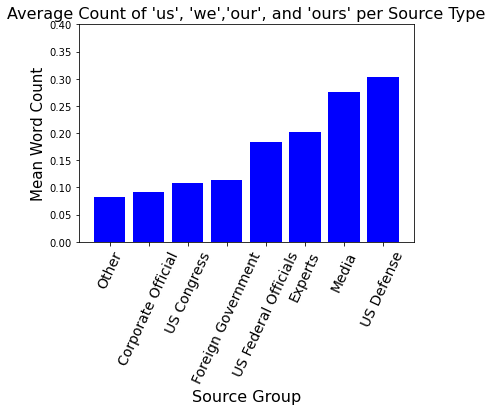

In [127]:
# making bar chart to visualize
plt.bar(x = grouped_word.index.to_series(), height = grouped_word["Average Word Count"], color = "blue")
plt.title("Average Count of 'us', 'we','our', and 'ours' per Source Type", fontdict = {'fontsize' : 16})
plt.ylim(0, 0.4)
plt.xlabel("Source Group", fontdict = {'fontsize' : 16})
plt.ylabel("Mean Word Count", fontdict = {'fontsize' : 15})
plt.xticks(np.arange(8), grouped_word.index.to_series(), fontdict = {'fontsize' : 14}, rotation= 65);


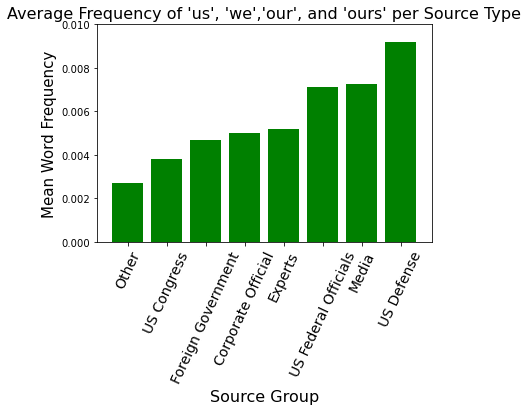

In [157]:
# making bar chart to visualize
plt.bar(x = grouped_word_freq.index.to_series(), height = grouped_word_freq["Average Word Frequency"], color = "green")
plt.title("Average Frequency of 'us', 'we','our', and 'ours' per Source Type", fontdict = {'fontsize' : 16})
plt.ylim(0, 0.01)
plt.xlabel("Source Group", fontdict = {'fontsize' : 16})
plt.ylabel("Mean Word Frequency", fontdict = {'fontsize' : 15})
plt.xticks(np.arange(8), grouped_word_freq.index.to_series(), fontdict = {'fontsize' : 14}, rotation= 65);